1. Bibliothèques importées avec succès.

2. Données chargées. Taille du dataset : (115609, 41)
   Aperçu des colonnes : ['Unnamed: 0', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city'] ...

   Taille du jeu d'entraînement : (80926, 7)
   Distribution de la cible (Satisfait=1/Insatisfait=0) :
is_satisfied
1    0.755344
0    0.244656
Name: proportion, dtype: float64

3. Définition du Prétraitement (Pipeline)...
   Prétraitement défini pour les caractéristiques numériques et catégorielles.

4. Analyse Exploratoire (EDA) de la Cible...


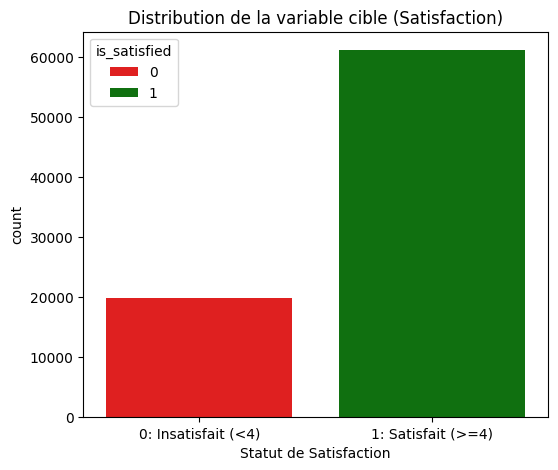


   Statistiques de la colonne originale 'review_score' :
count    115609.000000
mean          4.034409
std           1.385584
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64
   EDA terminée.

5. Création et entraînement du Modèle...
   Modèle entraîné avec succès sur la pipeline (Prétraitement inclus).

6. Évaluation des performances...
   >>> Accuracy Score : 75.59%

   >>> Rapport de Classification :
                 precision    recall  f1-score   support

Insatisfait (0)       0.53      0.02      0.04      8485
  Satisfait (1)       0.76      0.99      0.86     26198

       accuracy                           0.76     34683
      macro avg       0.64      0.51      0.45     34683
   weighted avg       0.70      0.76      0.66     34683



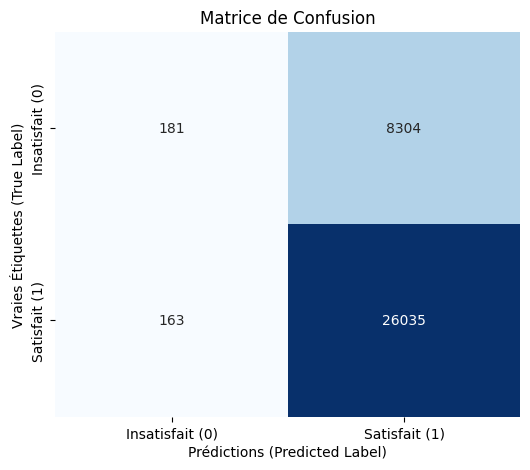


7. Fin du processus.



In [2]:
# ==============================================================================
# CYCLE DE VIE DATA SCIENCE APPLIQUÉ À database_p4.csv
# Objectif : Prédire la satisfaction client (Satisfaction >= 4)
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. IMPORTATION DES BIBLIOTHÈQUES
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

print("1. Bibliothèques importées avec succès.\n")

# ------------------------------------------------------------------------------
# 2. CHARGEMENT DES DONNÉES ET DÉFINITION DE LA CIBLE (Y)
# ------------------------------------------------------------------------------

# Chargement du fichier CSV avec le délimiteur spécifié (\t)
# Le fichier peut contenir des lignes vides ou mal formées, ajoutons error_bad_lines=False et engine='python'
try:
    df = pd.read_csv('/content/drive/MyDrive/projet/database_p4.csv', sep='\t', engine='python', on_bad_lines='skip')
except Exception as e:
    print(f"Erreur de chargement du fichier: {e}")
    # Si le chargement échoue, on arrête
    exit()

print(f"2. Données chargées. Taille du dataset : {df.shape}")
print(f"   Aperçu des colonnes : {df.columns.tolist()[:5]} ...\n")

# --- Définition de la CIBLE (Y) ---
# Création de la variable cible binaire 'is_satisfied'
# 1 = Satisfait (review_score >= 4), 0 = Insatisfait (review_score < 4)
df['is_satisfied'] = df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Filtrer les lignes sans score de revue (NaN) si nécessaire
df.dropna(subset=['review_score'], inplace=True) # S'assurer que nous avons un score de revue

y = df['is_satisfied']

# --- Sélection des CARACTÉRISTIQUES (X) pour la modélisation ---
# Nous sélectionnons quelques colonnes numériques et catégorielles pour la démo.
# CECI DOIT ÊTRE AFFINÉ PAR L'INGÉNIERIE DE CARACTÉRISTIQUES RÉELLE !
features_to_use = [
    'payment_installments', 'payment_value', 'price', 'freight_value',
    'product_category_name_english', 'customer_state', 'seller_state',
    # Calculer un 'time_to_delivery' (à ajouter en Ingénierie des Caractéristiques si besoin)
]

X = df[features_to_use]

# Séparation des jeux d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"   Taille du jeu d'entraînement : {X_train.shape}")
print(f"   Distribution de la cible (Satisfait=1/Insatisfait=0) :\n{y_train.value_counts(normalize=True)}\n")


# ------------------------------------------------------------------------------
# 3. PRÉTRAITEMENT AVEC PIPELINE (Remplacement des étapes 3 et 4 précédentes)
#    Gérer les valeurs manquantes (NaN) et la mise à l'échelle/encodage
# ------------------------------------------------------------------------------
print("3. Définition du Prétraitement (Pipeline)...")

# Identification des types de colonnes pour le prétraitement
numerical_features = ['payment_installments', 'payment_value', 'price', 'freight_value']
categorical_features = ['product_category_name_english', 'customer_state', 'seller_state']


# Création des transformateurs pour chaque type de colonne
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Remplacer les NaN par la moyenne
    ('scaler', StandardScaler())                 # Mettre à l'échelle (StandardScaler)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Remplacer les NaN
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                    # Encodage One-Hot
])

# Combiner les transformateurs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Ne pas modifier les colonnes restantes (si elles existent)
)

print("   Prétraitement défini pour les caractéristiques numériques et catégorielles.\n")
#

# ------------------------------------------------------------------------------
# 4. ANALYSE EXPLORATOIRE DES DONNÉES (EDA) (Focus sur la cible)
# ------------------------------------------------------------------------------
print("4. Analyse Exploratoire (EDA) de la Cible...")

# A. Distribution de la cible
plt.figure(figsize=(6, 5))
sns.countplot(x=y_train, hue=y_train, palette=['red', 'green'])
plt.title('Distribution de la variable cible (Satisfaction)')
plt.xticks([0, 1], ['0: Insatisfait (<4)', '1: Satisfait (>=4)'])
plt.xlabel("Statut de Satisfaction")
plt.show()

# B. Statistiques sur la colonne 'review_score' originale
print("\n   Statistiques de la colonne originale 'review_score' :")
print(df['review_score'].describe())
print("   EDA terminée.\n")


# ------------------------------------------------------------------------------
# 5. MODÉLISATION AVEC PIPELINE (Régression Logistique)
# (Remplacement des étapes 6 et 7 précédentes)
# ------------------------------------------------------------------------------
print("5. Création et entraînement du Modèle...")

# Créer la pipeline complète : Prétraitement + Modèle
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Entraînement du modèle sur les données d'entraînement
model_pipeline.fit(X_train, y_train)
print("   Modèle entraîné avec succès sur la pipeline (Prétraitement inclus).\n")


# ------------------------------------------------------------------------------
# 6. ÉVALUATION ET PERFORMANCE (Remplacement de l'étape 8 précédente)
# ------------------------------------------------------------------------------
print("6. Évaluation des performances...")

# Prédictions sur le jeu de test
y_pred = model_pipeline.predict(X_test)

# A. Accuracy (Précision globale)
acc = accuracy_score(y_test, y_pred)
print(f"   >>> Accuracy Score : {acc*100:.2f}%")

# B. Rapport détaillé
target_names = ['Insatisfait (0)', 'Satisfait (1)']
print("\n   >>> Rapport de Classification :")
print(classification_report(y_test, y_pred, target_names=target_names))

# C. Matrice de Confusion Visuelle
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraies Étiquettes (True Label)')
plt.xlabel('Prédictions (Predicted Label)')
plt.show()

print("\n7. Fin du processus.\n")